<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "11F"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/11F/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


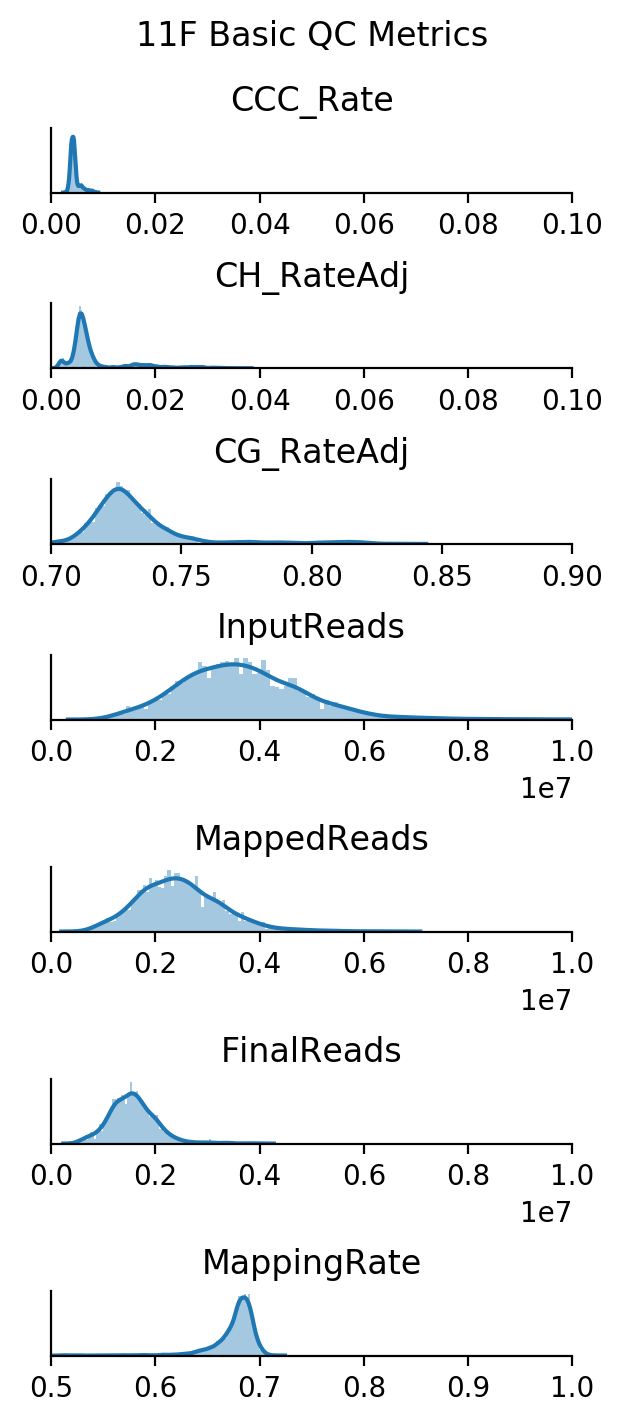

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

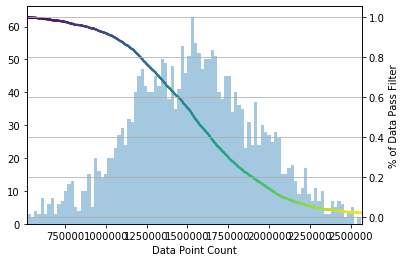

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2454/2454 (100.0%)
CG_RateAdj passed 2454/2454 (100.0%)
CH_RateAdj passed 2454/2454 (100.0%)
FinalReads passed 2454/2454 (100.0%)
MappingRate passed 2454/2454 (100.0%)
Overall passed 2454/2454 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
190214 1254
190305 1200


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 290 75.5%
ad002 305 79.4%
ad004 312 81.2%
ad006 305 79.4%
ad007 299 77.9%
ad008 301 78.4%
ad010 320 83.3%
ad012 322 83.9%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
11F_M_0,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.004482,0.718406,0.717139,0.009909,0.005452,1478269.0,3538522,2397473.0,11F,...,-17.225965,-8.200611,10.606406,4.350001,DG dg-all,0.163195,-9.594022,15.974393,-10.791658,True
11F_M_1,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.004731,0.732070,0.730796,0.010135,0.005430,1940368.0,4718598,3239527.0,11F,...,-17.189880,-7.144782,16.854267,2.698661,DG dg-all,1.427751,-9.707378,19.770241,-22.177143,True
11F_M_10,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.006340,0.795417,0.794112,0.025119,0.018900,1449214.0,3394730,2216926.0,11F,...,26.209255,9.460393,-14.502887,-24.332194,CT-L6 Il1rap,-1.086943,-22.771631,-23.798748,-17.451649,True
11F_M_100,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.007076,0.754581,0.752832,0.030401,0.023491,1594918.0,3843834,2591985.0,11F,...,6.025522,-11.399994,-17.886679,43.810516,Gfra1 Gfra1,-1.820715,5.539999,-1.883258,0.681229,True
11F_M_1000,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.004242,0.737577,0.736459,0.008681,0.004458,1596807.0,3763794,2540324.0,11F,...,-5.655231,6.396125,2.987874,-37.949693,ASC str-hpf,7.441610,-1.117903,-16.460155,-14.281153,True
11F_M_1001,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.004436,0.716470,0.715207,0.010927,0.006520,1846318.0,4415874,2988507.0,11F,...,-14.221782,-10.954226,-6.425861,25.299127,DG dg-all,4.874161,-4.775874,-10.756708,-26.494737,True
11F_M_1002,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.004380,0.729846,0.728658,0.010961,0.006610,1861537.0,4472690,3016929.0,11F,...,-16.002522,-13.685446,-18.382226,14.889874,DG dg-all,1.435501,-1.706521,-24.304615,-9.414642,True
11F_M_1003,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.004580,0.733821,0.732597,0.011652,0.007105,2009527.0,4882700,3247237.0,11F,...,-14.261940,-13.016831,-14.572438,23.072516,DG dg-all,4.789868,-3.087273,-15.875439,-25.443039,True
11F_M_1004,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.004351,0.720396,0.719174,0.010232,0.005906,1799233.0,4301766,2949922.0,11F,...,-15.223553,-10.061664,-1.173493,21.189544,DG dg-all,2.173080,-7.018651,3.495611,-22.754273,True
11F_M_1005,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.004129,0.712231,0.711037,0.009050,0.004941,1314111.0,3348536,2130967.0,11F,...,-17.078701,-7.393542,15.135199,6.101583,DG dg-all,-0.239855,-9.612523,17.462964,-11.664999,True
